<a href="https://colab.research.google.com/github/githublior/Gesture-detection-from-sensors-/blob/main/mvmt_detection_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/My Drive/mvmt_detection_project/Data
%pwd
%ls

/content/gdrive/My Drive/mvmt_detection_project/Data
'10 ms'/  '50 ms'/   Features.csv


In [ ]:
nbr_of_line_to_take_in_file = 12000
SAMPLE_SIZE = 8000/50  # 8 second example  = 8000ms/50ms timsestamps 
print(SAMPLE_SIZE)
print('nbr of example of special mvmt in train + dev:', nbr_of_line_to_take_in_file/SAMPLE_SIZE)

160.0
nbr of example of special mvmt in train + dev: 75.0


 data extraction, labelization , and adding magnitude

In [ ]:

import pandas as pd
import numpy as np

general_path_to_data = '../Data/50 ms/'
COLUMNS = ['timestamp', 'xAxis', 'yAxis', 'zAxis']
SENSORS_FILE = ['accelerometer.csv', 'gyroscope.csv', 'magneticfield.csv']
MVMT_KIND =['special_movement', 'free_movement_2']


def read_sensor(sensor, names_var, path):
  read_sensor = pd.read_csv(path + sensor, header=None, 
                              names=names_var)[1:nbr_of_line_to_take_in_file]  #  12 second record

  return  read_sensor.astype(float)

free_path = general_path_to_data  + MVMT_KIND[-1]+'/'
ACCELEROMETER_free =  read_sensor(SENSORS_FILE[0], COLUMNS, free_path)
ACCELEROMETER_free.name = 'ACCELEROMETER_free'
GYROSCOPE_free =  read_sensor(SENSORS_FILE[1], COLUMNS, free_path)
GYROSCOPE_free.name= 'GYROSCOPE_free'
MAGNETICFIELD_free = read_sensor(SENSORS_FILE[2], COLUMNS, free_path)
MAGNETICFIELD_free.name = 'MAGNETICFIELD_free'


special_path = general_path_to_data  + MVMT_KIND[0]+'/'
ACCELEROMETER_special =  read_sensor(SENSORS_FILE[0], COLUMNS, special_path)
ACCELEROMETER_special.name = 'ACCELEROMETER_special'
GYROSCOPE_special =  read_sensor(SENSORS_FILE[1], COLUMNS, special_path)
GYROSCOPE_special.name= 'GYROSCOPE_special'
MAGNETICFIELD_special = read_sensor(SENSORS_FILE[2], COLUMNS, special_path)
MAGNETICFIELD_special.name = 'MAGNETICFIELD_special'
PROXIMITY_special = read_sensor('proximity.csv',['timestamp', 'distance'], special_path)
PROXIMITY_special.name = 'PROXIMITY_special'


ACCELEROMETER_free.head()

,timestamp,xAxis,yAxis,zAxis
1,35.0,6.06230,1.34798,7.48690
2,85.0,6.13174,1.19953,7.54197
3,136.0,6.11258,1.21150,7.40789
4,185.0,6.13653,1.33361,7.37197
5,236.0,6.13892,1.20432,7.45338


In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, activity['timestamp'], activity['xAxis'], 'x Axis')
    plot_axis(ax1, activity['timestamp'], activity['yAxis'], 'y Axis')
    plot_axis(ax2, activity['timestamp'], activity['zAxis'], 'z Axis')
    plt.subplots_adjust(hspace=0.2)
    plt.show()

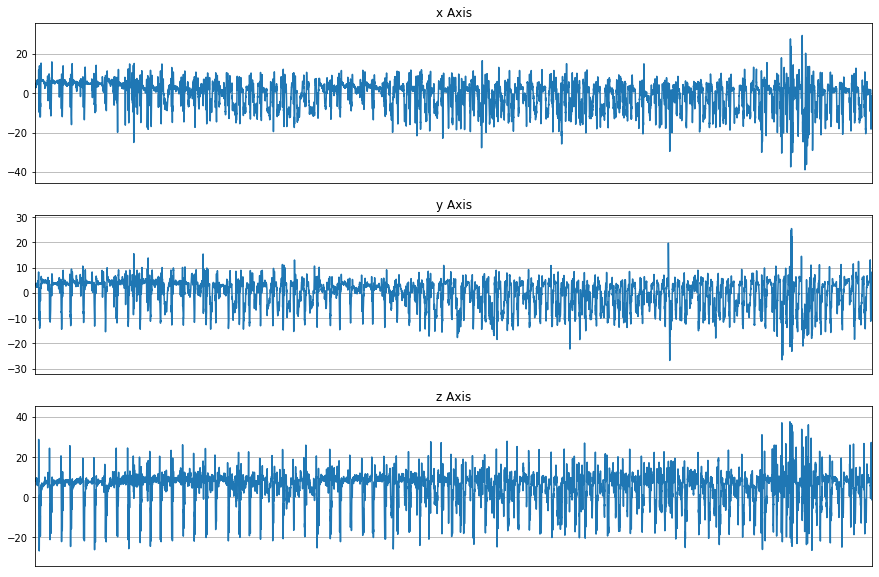

In [ ]:
plot_activity(ACCELEROMETER_special)


In [ ]:
import math

def magnitude(activity):
    x2 = activity['xAxis'] * activity['xAxis']
    y2 = activity['yAxis'] * activity['yAxis']
    z2 = activity['zAxis'] * activity['zAxis']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

In [ ]:
ACCELEROMETER_special['magnitude'] = magnitude(ACCELEROMETER_special)
GYROSCOPE_special['magnitude'] = magnitude(GYROSCOPE_special)
MAGNETICFIELD_special['magnitude'] = magnitude(MAGNETICFIELD_special)

ACCELEROMETER_free['magnitude'] = magnitude(ACCELEROMETER_free)
GYROSCOPE_free['magnitude'] = magnitude(GYROSCOPE_free)
MAGNETICFIELD_free['magnitude'] = magnitude(MAGNETICFIELD_free)

In [ ]:
def plot_magnitudes(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(15, 15))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['timestamp'], activities[i]['magnitude'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

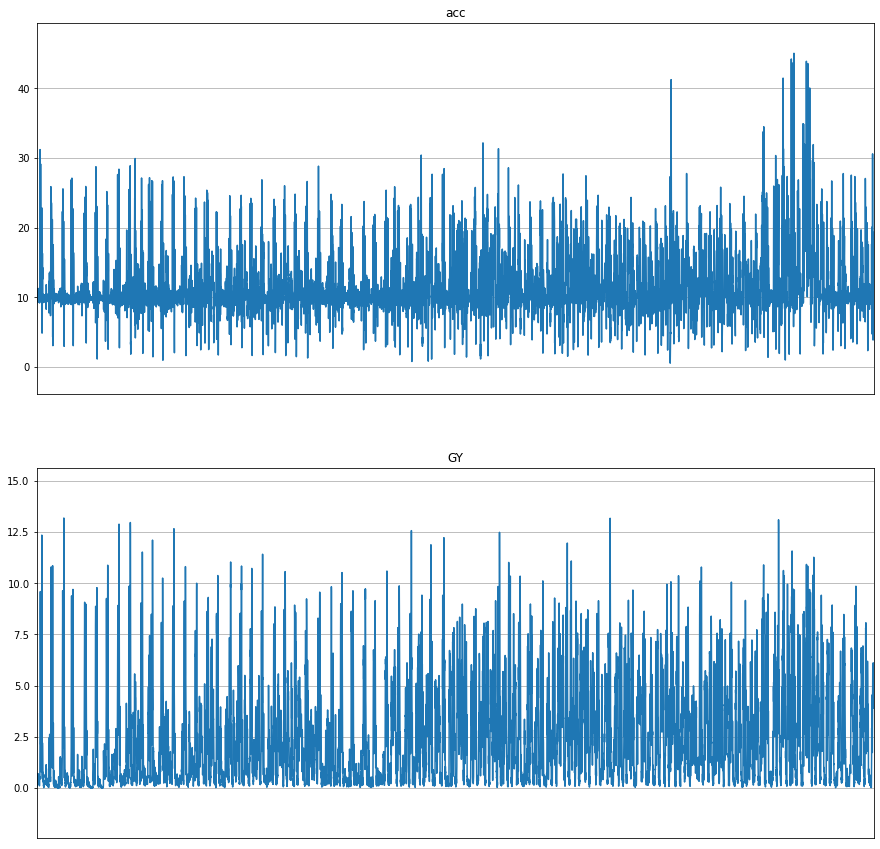

In [ ]:
plot_magnitudes([ACCELEROMETER_special, GYROSCOPE_special], ['acc','GY'])

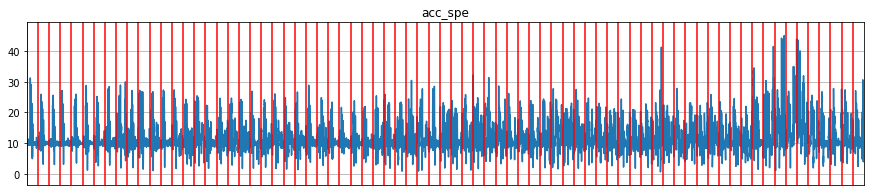

In [ ]:
def windows(df, size=SAMPLE_SIZE):
    start = 1
    while start < df.count():
        yield start, start + size
        start += (size)

fig, ax = plt.subplots(nrows=1, figsize=(15, 3))
plot_axis(ax, ACCELEROMETER_special['timestamp'], ACCELEROMETER_special['magnitude'], 'acc_spe')

for (start, end) in windows(ACCELEROMETER_special['timestamp']):
    ax.axvline(x=ACCELEROMETER_special['timestamp'][int(start)], color='r')
    
plt.show()

In [ ]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa import stattools
import numpy as np
import math

def jitter(axis, start, end):
    j = float(0)
    for i in range(start, min(end, axis.count())):
        if start != 1:
            j += abs(axis[i] - axis[i-1])
    
    return j / (end-start)

def mean_crossing_rate(axis, start, end):
    cr = 0
    m = axis.mean()
    for i in range(start, min(end, axis.count())):
        if start != 1:
            p = axis[i-1] > m
            c = axis[i] > m
            if p != c:
                cr += 1
    return float(cr) / (end-start-1)

def window_summary(axis, start, end):
    start = int(start)
    end = int(end)
    acf = stattools.acf(axis[start:end])
    acv = stattools.acovf(axis[start:end])
    sqd_error = (axis[start:end] - axis[start:end].mean()) ** 2
    return [
        jitter(axis, start, end),     
        mean_crossing_rate(axis, start, end),
        axis[start:end].mean(),
        axis[start:end].std(),
        axis[start:end].var(),
        axis[start:end].min(),
        axis[start:end].max(),
        acf.mean(), # mean auto correlation
        acf.std(), # standard deviation auto correlation
        acv.mean(), # mean auto covariance
        acv.std(), # standard deviation auto covariance
        skew(axis[start:end]),
        kurtosis(axis[start:end]),
        math.sqrt(sqd_error.mean())
    ]

Variables_in_sensor_without_timestamp = ['xAxis', 'yAxis', 'zAxis', 'magnitude']
free_sensors = [ACCELEROMETER_free, GYROSCOPE_free, MAGNETICFIELD_free]
special_sensors = [ACCELEROMETER_special, GYROSCOPE_special, MAGNETICFIELD_special]

def create_activities():

  free = pd.DataFrame()
  free['timestamp'] = ACCELEROMETER_free['timestamp']
  for sensor in free_sensors:
    for variable in Variables_in_sensor_without_timestamp:
      free[sensor.name + '_' + variable] = sensor[variable]

  special = pd.DataFrame()
  special['timestamp'] = ACCELEROMETER_special['timestamp']
  for sensor in special_sensors:
    for variable in Variables_in_sensor_without_timestamp:
      special[sensor.name + '_' + variable] = sensor[variable]

  return [ free, special]

def free_features(activity):
    for (start, end) in windows(activity['timestamp']):
        features = []
        for sensor in free_sensors:       
          for variable in Variables_in_sensor_without_timestamp:
              features += window_summary(activity[sensor.name + '_' + variable], start, end)
        yield features


def special_features(activity):
    for (start, end) in windows(activity['timestamp']):
        features = []
        for sensor in special_sensors:       
          for variable in Variables_in_sensor_without_timestamp:
              features += window_summary(activity[sensor.name + '_' + variable], start, end)
        yield features

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import csv

activities = create_activities()
# 0 corresp label free
# 1 corresp label special
with open('../Data/Features.csv', 'w') as out:
    rows = csv.writer(out)
    l =0
  
    for f in free_features(activities[0]):
      l+=1
      rows.writerow([0] +  f)
    for f in special_features(activities[1]):
      l+=1
      rows.writerow([1] +  f)
print(l)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:354: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


150


In [ ]:
dataset = np.loadtxt('../Data/Features.csv', delimiter=",")
X = dataset[:, 1:]
y = dataset[:, 0]
# print(X,y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

c = RandomForestClassifier()
b = DummyClassifier() # generates predictions by respecting the training set's class distribution

results = []
baselines = []
for i in range(0, 50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    c.fit(X_train, y_train)
    b.fit(X_train, y_train)
    res = c.score(X_test, y_test)
    bas = b.score(X_test, y_test)
    print('Loop', i, res, bas)
    results.append(res)
    baselines.append(bas)

print('\nBaseline', np.mean(baselines), np.std(baselines))
print('Random Forest', np.mean(results), np.std(results))


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 0 1.0 0.55
Loop 1 1.0 0.5833333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 2 1.0 0.4166666666666667
Loop 3 1.0 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 4 1.0 0.45
Loop 5 1.0 0.48333333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 6 1.0 0.5166666666666667
Loop 7 1.0 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 8 1.0 0.5166666666666667
Loop 9 1.0 0.5333333333333333


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 10 1.0 0.5166666666666667
Loop 11 1.0 0.48333333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 12 1.0 0.5833333333333334
Loop 13 1.0 0.45


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 14 1.0 0.5333333333333333
Loop 15 1.0 0.4666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 16 1.0 0.5166666666666667
Loop 17 1.0 0.38333333333333336


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 18 1.0 0.48333333333333334
Loop 19 1.0 0.48333333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 20 1.0 0.5166666666666667
Loop 21 1.0 0.43333333333333335


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 22 1.0 0.55
Loop 23 1.0 0.38333333333333336


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 24 1.0 0.4666666666666667
Loop 25 1.0 0.5833333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 26 1.0 0.5
Loop 27 1.0 0.5166666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 28 1.0 0.45
Loop 29 1.0 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 30 1.0 0.55
Loop 31 1.0 0.45


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 32 1.0 0.5833333333333334
Loop 33 1.0 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 34 0.9833333333333333 0.5333333333333333
Loop 35 1.0 0.48333333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 36 1.0 0.45
Loop 37 1.0 0.31666666666666665


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 38 1.0 0.6
Loop 39 1.0 0.4166666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 40 1.0 0.5666666666666667
Loop 41 1.0 0.5166666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 42 1.0 0.6
Loop 43 1.0 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 44 1.0 0.45
Loop 45 1.0 0.45


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Loop 46 1.0 0.38333333333333336
Loop 47 0.9833333333333333 0.4666666666666667
Loop 48 1.0 0.4166666666666667
Loop 49 1.0 0.5333333333333333

Baseline 0.49433333333333346 0.06268173577685927
Random Forest 0.9993333333333334 0.003265986323710914


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [ ]:


# MVMT classification TEST : loading the test file and their sensors
test_path = general_path_to_data + 'test_3_free/'
ACC_TEST = read_sensor(SENSORS_FILE[0], COLUMNS, test_path)
ACC_TEST.name = 'ACC_TEST'
GY_TEST = read_sensor(SENSORS_FILE[1], COLUMNS, test_path)
GY_TEST.name = 'GY_TEST'
MG_TEST = read_sensor(SENSORS_FILE[2], COLUMNS, test_path)
MG_TEST.name = 'MG_TEST'
  
ACC_TEST['magnitude'] = magnitude(ACC_TEST)
GY_TEST['magnitude'] = magnitude(GY_TEST)
MG_TEST['magnitude'] = magnitude(MG_TEST)


Variables_in_sensor_without_timestamp = ['xAxis', 'yAxis', 'zAxis', 'magnitude']
test_sensors = [ACC_TEST, GY_TEST, MG_TEST]

def dev_activity():

  test = pd.DataFrame()
  test['timestamp'] = ACC_TEST['timestamp']
  for sensor in test_sensors:
    for variable in Variables_in_sensor_without_timestamp:
      test[sensor.name + '_' + variable] = sensor[variable]
  return test


def dev_features(activity):
    for (start, end) in windows(activity['timestamp']):
        features = []
        for sensor in test_sensors:       
          for variable in Variables_in_sensor_without_timestamp:
              features += window_summary(activity[sensor.name + '_' + variable], start, end)
        yield features



W = [f for f in dev_features(dev_activity())]
# out_of_random_forest =int(c.predict(W)[0])
# print(out_of_random_forest)  #if 0 free, if 1 special

random_forest_predict = []
for i in range(0, 50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    c.fit(X, y)
    random_forest_predict.append(int(c.predict(W)[0]))  #if 0 free, if 1 special
print('average output prediction:',np.mean(random_forest_predict))
print(random_forest_predict)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:354: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


average output prediction: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


DETECT WHERE START AND END THE MVT IN SPECIAL SEQUENCE

In [ ]:
def get_start_end_for_short_seq(start,end, PROXIMITY_special):
  ''' given a single example - selected by a [stard, end] window-
  and the proximity sensor from the overall special mvt, 
  return the start_mvt and end_mvt indx (to convert in timestamp for real value.)'''
  first_0_serie = False
  second_0_serie = False
  switch_to_second = False
  pbm = True
  
  i = start
  while (i <=end):
    if int(PROXIMITY_special['distance'][i]) ==0: first_0_serie = True
    if int(PROXIMITY_special['distance'][i])!=0 and first_0_serie == True : 
      start_mvt_index = i-1
      switch_to_second = True
      pbm = False
    i+=1
    if switch_to_second == True: break


  if pbm == True: 
    print('NO 0-PROXIMITY ON THE FULL SEQUENCE ')
    return 'problem no - proximity in the sequence'
  else:
    while(i <= end):
      if int(PROXIMITY_special['distance'][i]) == 0: 
        second_0_serie = True
      if int(PROXIMITY_special['distance'][i])!= 0 and second_0_serie == True : 
        end_mvt_index = i-1
        return int(start_mvt_index), int(end_mvt_index)
      i+=1
  return 'problem _ no *end* proximity in sequence ' 





In [ ]:




'''create s_e_special_label: list of window with its start_mvt and end_mvt indexes.
create dev_set: take the 1/5th last window of the df special and convert
 them to list of example to test. include the timestamp  '''
s_e_special_label = []
dev_set = []
train_set = [] 
dataset = []
for (start, end) in windows(ACCELEROMETER_special['timestamp']):
  ''' create s_e_special_label: list of [start_mvt,end_mvt] for each window/example '''
  s_mvt, e_mvt = get_start_end_for_short_seq(start,end, PROXIMITY_special)
  s_e_special_label.append([s_mvt, e_mvt])
  if start >= 60 * SAMPLE_SIZE : 
    ''' convert the last fifth of special (df) to list called dev_set 
    each row composed of :[list of timestamps and their var, s&e in free, s_mvt&e_mvt] '''
    int_start = int(start)
    int_end = int(end)
    one_ex = []
    for t in range(int_start,int_end-1):
      one_ex.append([ACCELEROMETER_special['timestamp'][t], ACCELEROMETER_special['xAxis'][t], ACCELEROMETER_special['yAxis'][t], ACCELEROMETER_special['zAxis'][t],
                    GYROSCOPE_special['xAxis'][t], GYROSCOPE_special['yAxis'][t], GYROSCOPE_special['zAxis'][t],
                    MAGNETICFIELD_special['xAxis'][t], MAGNETICFIELD_special['yAxis'][t], MAGNETICFIELD_special['zAxis'][t]])
    
    dev_set.append([one_ex,[int_start, int_end],[s_mvt, e_mvt]])
  else :
    int_start = int(start)
    int_end = int(end)
    one_ex = []
    for t in range(int_start,int_end-1):
      one_ex.append([ACCELEROMETER_special['timestamp'][t], ACCELEROMETER_special['xAxis'][t], ACCELEROMETER_special['yAxis'][t], ACCELEROMETER_special['zAxis'][t],
                    GYROSCOPE_special['xAxis'][t], GYROSCOPE_special['yAxis'][t], GYROSCOPE_special['zAxis'][t],
                    MAGNETICFIELD_special['xAxis'][t], MAGNETICFIELD_special['yAxis'][t], MAGNETICFIELD_special['zAxis'][t]])
    
    train_set.append([one_ex,[int_start, int_end],[s_mvt, e_mvt]])
  
  int_start = int(start)
  int_end = int(end)
  one_ex = []
  for t in range(int_start,int_end-1):
    one_ex.append([ACCELEROMETER_special['timestamp'][t], ACCELEROMETER_special['xAxis'][t], ACCELEROMETER_special['yAxis'][t], ACCELEROMETER_special['zAxis'][t],
                  GYROSCOPE_special['xAxis'][t], GYROSCOPE_special['yAxis'][t], GYROSCOPE_special['zAxis'][t],
                  MAGNETICFIELD_special['xAxis'][t], MAGNETICFIELD_special['yAxis'][t], MAGNETICFIELD_special['zAxis'][t]])
  
  dataset.append([one_ex,[int_start, int_end],[s_mvt, e_mvt]])
  


# print(s_e_special_label[66])
print(len(dataset))

75


In [ ]:
def get_min_max_mvt_time(s_e_special_label):
  min_time = 100000
  max_time =0
  min_i = 10000
  for i in range(len(s_e_special_label)):
    diff = s_e_special_label[i][1] - s_e_special_label[i][0]
    if diff < min_time : 
      min_time = diff
      min_i = i
    if diff > max_time : max_time = diff
  # print(min_i)
  return min_time, max_time

min_time_mvt , max_time_mvt = get_min_max_mvt_time(s_e_special_label)
print(min_time_mvt, max_time_mvt)


16 94


In [ ]:
def crop_trained_special_mvt(s_e_special_label, special):
  '''return cropped_special: a list of 4/5 of the examples (60/75)
  that starts and ends exactly when the special mvmt occures  
  careful: cropped inclued columns timestamp'''
  cropped_special = []
  full_special = []
  for start, end  in s_e_special_label:
    if end <=(4/5)* len(special):
      cropped_one_example= []
      cropped_one_example = special.iloc[start-1:end].values.tolist()
      cropped_special.append(cropped_one_example)
  return cropped_special

cropped_special = crop_trained_special_mvt(s_e_special_label, activities[-1])

# print('nbr of timestamp in one cropped_example:', len(cropped_special[0]))
# print('nbr variables in one timestamp:', len(cropped_special[0][0]))
# print(len(activities[-1]))
print(cropped_special[0][0])  # for une example : each row is a timestamp (form s_mvt to e_mvt) and contains timestamp + 3*4 sensors values

[2188.0, 5.36557, 3.51719, 6.56031, 9.175926885993588, -0.2571, 0.15111, 0.14548, 0.3318118028340764, -21.48, 10.5, -35.22, 42.56863634179512]


In [ ]:

def crop_trained_special_mvt_without_magnitude(s_e_special_label, special):
  '''return cropped_special: a list of 4/5 of the examples (60/75)
  that starts and ends exactly when the special mvmt occures  
  careful: cropped inclued columns timestamp'''
  cropped_special = []
  indx_start_in_full_ex =0
  for i in range(len(s_e_special_label)):
    start = s_e_special_label[i][0]
    end = s_e_special_label[i][1]
    cropped_one_example= []
    cropped_one_example = special[i][0][start-indx_start_in_full_ex:end - indx_start_in_full_ex]
    indx_start_in_full_ex += len(special[i][0])
    cropped_special.append(cropped_one_example)
  return cropped_special

cropped_special = crop_trained_special_mvt_without_magnitude(s_e_special_label, dataset)


print(cropped_special[-1][-1])  # for one example : each row is a timestamp (form s_mvt to e_mvt) and contains timestamp + 3*3 sensors values



[599947.0, -1.3384, 4.32406, 8.9498, 0.23892, -2.49821, 2.986, 14.46, -27.48, -24.18]


In [ ]:
# print(dev_set[10])
from scipy.spatial import distance


'''CREATE Dynamic Time Warping between 2 matrix'''

def DTW(mat1,mat2):
  s= [[0 for col in range(len(mat2))] for row in range(len(mat1))]
  for l1 in range(len(mat1)):
    for l2 in range(len(mat2)):
      dist= distance.cosine(mat1[l1], mat2[l2])
      s[l1][l2] += dist
  d = np.zeros_like(s)
  for i in range(len(mat1)):
    for j in range(len(mat2)):
      if i==0 and j==0: 
         d[i,j] = s[i][j]

      elif i==0: 
        d[i,j] = d[i,j-1] + s[i][j]

      elif j==0:
         d[i,j] = d[i-1,j] + s[i][j]

      else: 
        d[i,j] = np.min([d[i-1,j],d[i,j-1],d[i-1,j-1]]) + s[i][j]

  return d , s

def retrive_align_path(d):
  i = len(d)-1
  j =len(d[0])-1
  current = d[i][j]
  align_path = [[i,j]]
  while i!=0 and j !=0 :
    a = d[i][j-1]
    b= d[i-1][j]
    c = d[i-1][j-1]
    mi = np.min([a, b, c])

    if mi == a: 
      align_path.insert(0, [i,j-1])
      j = j-1
    if mi == b: 
      align_path.insert(0,[i-1,j])
      i = i-1
    if mi == c: 
      align_path.insert(0,[i-1,j-1])
      j = j-1
      i = i-1
  return align_path

def plot_diff_align_path(path_value, string, title, actual_start_mvt_rel,actual_end_mvt_rel):
  t = np.arange(0,len(path_value),1)
  # print(t)
  s = path_value

  fig, ax = plt.subplots()
  ax.plot(t, s, color = string)

  ax.set(xlabel='time (s)', ylabel='diff ',
        title=title)
  ax.axvline(x=actual_start_mvt_rel, color='r')
  ax.axvline(x=actual_end_mvt_rel, color='r')

  plt.show()

def get_s_e_mvt_from_align_path(align_path):
  # print('align_path :', align_path)
  ''' this function return the predicted start and end index of the test expl
  according to the alignement path of the DTW[train_expl, test_expl]'''
  check1 = False
  check2 = False
  for i in range(1,len(align_path)):
    if align_path[i][0] > align_path[i-1][0] :
      predicted_start_indx = align_path[i][1]
      check1 = True
      break
  if check1 == False : print('NO FINDING START : PBM')
  for j in range(len(align_path)-2,0,-1):
    if align_path[j][0]<align_path[j+1][0]:
      predicted_end_indx = align_path[j][1]
      check2 = True
      break
  if check2 == False : print('NO FINDING END : PBM')

  return predicted_start_indx, predicted_end_indx
  

def predict_s_e_of_test_from_dtw_with_single_expl_cropped(single_cropped_expl, expl_to_test):
  ''' output the starting indx and ending indx mvt of the example to test
  according to DTW over a specific single_cropped_expl'''


  actual_start_mvt_index_abs = expl_to_test[1:][-1][0]
  actual_end_mvt_index_abs = expl_to_test[1:][-1][-1]
  actual_start_seq_index_abs  = expl_to_test[1:][0][0]
  actual_end_seq_index_abs  = expl_to_test[1:][0][-1]
  actual_start_mvt_rel = actual_start_mvt_index_abs - actual_start_seq_index_abs
  actual_end_mvt_rel = actual_end_seq_index_abs - actual_end_mvt_index_abs


  #remove timestamp and else before DTW
  to_test = np.array(expl_to_test[0])
  corrected_dim_expl_to_test = to_test[:,1:].tolist()

  one_cropped_expl  = np.array(single_cropped_expl)
  corrected_dim_cropped_example = one_cropped_expl[:, 1:]

  # apply DTW between 2 mat , retrieve alignment path , and get pred start an end
  d , s = DTW(corrected_dim_cropped_example, corrected_dim_expl_to_test) 
  path= retrive_align_path(d)

  ##plotting the alignment path from DTW
  # path_value= []
  # path_value.append(s[path[0][0]][path[0][1]])
  # path_difference_value1=[]
  # for t in range(1,len(path)):
  #   path_value.append(s[path[t][0]][path[t][1]])
  #   # path_difference_value.append(d[path[t][0]][path[t][1]] - d[path[t-1][0]][path[t-1][1]])
  # plot_diff_align_path(path_value, 'blue','DTW of vars', actual_start_mvt_rel, actual_end_mvt_rel)




  test_start_mvt_indx, test_end_mvt_indx = get_s_e_mvt_from_align_path(path)


  actual_start_mvt_in_timestamp = expl_to_test[0][actual_start_mvt_rel][0]
  actual_end_mvt_in_timestamp = expl_to_test[0][actual_end_mvt_rel][0]
  predicted_start_mvt_in_timestamp = expl_to_test[0][test_start_mvt_indx][0]
  predicted_end_mvt_in_timestamp =  expl_to_test[0][test_end_mvt_indx][0]

  # print('actual start mvt inx relative',actual_start_mvt_rel, 'end mvt rel ', actual_end_mvt_rel, 'over total of', actual_end_seq_index_abs - actual_start_seq_index_abs  )
  # print('start seq in timestamp:', expl_to_test[0][0][0], 'end seq in timestamp', expl_to_test[0][-1][0])
  # print('actual start', actual_start_mvt_in_timestamp , 'end', actual_end_mvt_in_timestamp)
  # print('predicted start', predicted_start_mvt_in_timestamp, 'end', predicted_end_mvt_in_timestamp)

  return actual_start_mvt_in_timestamp, actual_end_mvt_in_timestamp , predicted_start_mvt_in_timestamp , predicted_end_mvt_in_timestamp , d[-1][-1]
expl_to_test_nbr = -1
given_expl_nbr = 0

cropped = crop_trained_special_mvt_without_magnitude(s_e_special_label, dataset)

a_s,a_e , p_s, p_e, DTW_score = predict_s_e_of_test_from_dtw_with_single_expl_cropped(cropped[given_expl_nbr], dev_set[expl_to_test_nbr]) 
print('actual start', a_s , 'end', a_e)
print('predicted start', p_s, 'end', p_e)


# actual = []
# predicted = []
# difference = []
# for train_example in range(len(cropped_special)):
#   a_s,a_e , p_s, p_e = predict_s_e_of_test_from_dtw_with_single_expl_cropped(cropped_special[train_example], dev_set[0])  
#   actual.append([a_s,a_e])
#   predicted.append([p_s,p_e])
#   difference.append([abs(a_s - p_s), abs(a_e - p_e)])
# print(actual)
# print(predicted)
# print(difference)

actual start 593387.0 end 595237.0
predicted start 592088.0 end 599888.0


In [ ]:

def plot_ex(sensor_ax, first_ex ,second_ex=None):
  
  s_one = np.array(first_ex[0])[:,sensor_ax].tolist()
  t = np.arange(0,len(s_one),1)
  fig, ax = plt.subplots()
  ax.plot(t, s_one, color = 'blue')
  ax.set(xlabel='time (50 ms)', title=str(sensor_ax))

  actual_start_mvt_rel_one = first_ex[2][0]- first_ex[1][0]
  actual_end_mvt_rel_one = first_ex[2][1]- first_ex[1][0]
  ax.axvline(x=actual_start_mvt_rel_one, color='b')
  ax.axvline(x=actual_end_mvt_rel_one, color='b')

  if second_ex is not None:
    s_two = np.array(second_ex[0])[:,sensor_ax].tolist()
    ax.plot(t, s_two   , color = 'red')
    actual_start_mvt_rel_two = second_ex[2][0]- second_ex[1][0]
    actual_end_mvt_rel_two = second_ex[2][1]- second_ex[1][0]
    ax.axvline(x=actual_start_mvt_rel_two, color='r')
    ax.axvline(x=actual_end_mvt_rel_two, color='r')

  plt.show()


sensor_ax = 1 # i.e acc_x_axis
one = 0
two = one + 1
first_ex = train_set[one]
second_ex = train_set[two]

plot_ex(sensor_ax, first_ex, second_ex)

NameError: ignored

using cropped trained examples, try brut force to find the perfect match


In [ ]:

# big_border = int(len( dev_set[0][0]))#- 0.8*min_time_mvt)
# score_and_predict_matrix = [[[math.inf,math.inf, math.inf] for x in range(big_border) ] for y in range(big_border) ]
# for i in range(int(len( dev_set[0][0])- 0.8*min_time_mvt)):
#   for j in range(int(i + 0.8*min_time_mvt), min(int(i+ 1.2*max_time_mvt), len(dev_set[0][0]))):
#     a_s,a_e , p_s, p_e, DTW_score = predict_s_e_of_test_from_dtw_with_single_expl_cropped(
#         cropped_special[0], dev_set[0][0], i, j, dev_set[0][1:]) 
#     score_and_predict_matrix[i][j] = [DTW_score, p_s, p_e]
    
# lower = math.inf
# for i in range(len(score_and_predict_matrix)):
#   for j in range(len(score_and_predict_matrix[0])):
#     if score_and_predict_matrix[i][j][0] < lower :
#       lower =  score_and_predict_matrix[i][j][0]
#       best_p_s = score_and_predict_matrix[i][j][1]
#       best_p_e = score_and_predict_matrix[i][j][2]
# print('actual start', a_s , 'end', a_e)
# print('predicted start', p_s, 'end', p_e)



using full trained examples (i.e. not cropped), find good feature to feed DTW to find perfect match.

In [ ]:
from tabulate import tabulate
from sklearn.preprocessing import normalize
def DTW_0(mat1,mat2):
  s= [[0 for col in range(len(mat2))] for row in range(len(mat1))]
  for l1 in range(len(mat1)):
    for l2 in range(len(mat2)):
      dist= (distance.sqeuclidean(mat1[l1], mat2[l2]))
      s[l1][l2] += dist
  d = np.zeros_like(s)
  for i in range(len(mat1)):
    for j in range(len(mat2)):
      if i==0 and j==0: 
         d[i,j] = s[i][j]

      elif i==0: 
        d[i,j] = d[i,j-1] + s[i][j]

      elif j==0:
         d[i,j] = d[i-1,j] + s[i][j]

      else: 
        d[i,j] = np.min([d[i-1,j],d[i,j-1],d[i-1,j-1]]) + s[i][j]

  return d , s

def DTW_new1(mat1,mat2):
  # derivate_mat1 = mat_derivate(mat1)
  # derivate_mat2 = mat_derivate(mat2)

  # mat1 = normalize(mat1, axis=0)
  # mat2 = normalize(mat2, axis=0)

  mean_mat1 = mean_mat(mat1)
  mean_mat2 = mean_mat(mat2)

  var_mat1 = var_mat(mat1, mean_mat1)
  var_mat2 = var_mat(mat2, mean_mat2)
  # print('var mat 1',len(var_mat1))


  s= [[0 for col in range(len(mat1))] for row in range(len(mat2))]
  for l1 in range(len(mat1)):
    for l2 in range(len(mat2)):
      dist2= distance.cosine(var_mat1[l1], var_mat2[l2])
      # dist2 = distance.euclidean(derivate_mat1[l1], derivate_mat2[l2])
      # dist3 = distance = (difference variance a la moyene )**2
      s[l1][l2] += dist2
  d = np.zeros_like(s)
  for i in range(len(mat1)):
    for j in range(len(mat2)):
      if i==0 and j==0: 
         d[i,j] = s[i][j]

      elif i==0: 
        d[i,j] = d[i,j-1] + s[i][j]

      elif j==0:
         d[i,j] = d[i-1,j] + s[i][j]

      else: 
        d[i,j] = np.min([d[i-1,j],d[i,j-1],d[i-1,j-1]]) + s[i][j]

  return d.tolist() , s

def DTW_new2(mat1,mat2):
  # mat1 = normalize(mat1, axis=0)
  # mat2 = normalize(mat2, axis=0)

  derivate_mat1 = mat_derivate(mat1)
  derivate_mat2 = mat_derivate(mat2)

  # mean_mat1 = mean_mat(mat1)
  # mean_mat2 = mean_mat(mat2)

  # var_mat1 = var_mat(mat1, mean_mat1)
  # var_mat2 = var_mat(mat2, mean_mat2)
  # print('var mat 1',len(var_mat1))


  s= [[0 for col in range(len(derivate_mat1))] for row in range(len(derivate_mat2))]
  for l1 in range(len(derivate_mat1)):
    for l2 in range(len(derivate_mat2)):
      # dist2= distance.cosine(var_mat1[l1], var_mat2[l2])
      dist2 = distance.sqeuclidean(derivate_mat1[l1], derivate_mat2[l2])
      # dist3 = distance = (difference variance a la moyene )**2
      s[l1][l2] += dist2
  d = np.zeros_like(s)
  for i in range(len(derivate_mat1)):
    for j in range(len(derivate_mat2)):
      if i==0 and j==0: 
         d[i,j] = s[i][j]

      elif i==0: 
        d[i,j] = d[i,j-1] + s[i][j]

      elif j==0:
         d[i,j] = d[i-1,j] + s[i][j]

      else: 
        d[i,j] = np.min([d[i-1,j],d[i,j-1],d[i-1,j-1]]) + s[i][j]

  return d.tolist() , s

def Average(lst): 
    return sum(lst) / len(lst) 

def mat_derivate(mat):
  mat_derivate = []
  for line in range(len(mat)-1):
    for col in range(len(mat[0])):
     derivate_l1 =    abs(mat[line+1][col]-mat[line][col] )  
    mat_derivate.append(derivate_l1)
  mat_derivate.append(0) # add last elt in list for keeping correct dimension.
  return mat_derivate

def  mean_mat(mat):
  the_mean_mat= []
  for col in range(len(mat[0])):
    the_mean_mat.append(sum(mat[:][col])/len(mat[0]))
  return the_mean_mat

def var_mat(mat, mean_mat):
  var_mat = []
  for row in range(len(mat)):
    row_var = []
    for col in range(len(mat[0])):
      row_var.append((mat[row][col] - mean_mat[col])**2)
    var_mat.append(row_var)
  return var_mat

    
def get_predicted_start_end_from_path(path, s_mvt_of_trained,e_mvt_of_trained):
  predicted_s =0
  predicted_e=0
  indx_tr_s = 0
  indx_tr_e = 0 
  for k in range(len(path)):
    if path[k][0] == s_mvt_of_trained:
      predicted_s = path[k][1]
      indx_tr_s = path[k][0]
    if path[k][0] == e_mvt_of_trained:
      predicted_e = path[k][1]
      indx_tr_e =  path[k][0]
  return predicted_s , predicted_e , indx_tr_s, indx_tr_e
    

def plot_diff_align_path(path_value, string, title, actual_start_mvt_rel,actual_end_mvt_rel):
  t = np.arange(0,len(path_value),1)
  # print(t)
  s = path_value

  fig, ax = plt.subplots()
  ax.plot(t, s, color = string)

  ax.set(xlabel='time (s)', ylabel='diff ',
        title=title)
  ax.axvline(x=actual_start_mvt_rel, color='r')
  ax.axvline(x=actual_end_mvt_rel, color='r')

  plt.show()

def predict_s_e_of_test_from_dtw_with_single_expl_NOT_cropped(indx_expl, indx_test, full_expl_list):
  ''' output the starting indx and ending indx mvt of the example to test
  according to DTW over a specific single_not_cropped_expl'''
  not_cropped = full_expl_list[indx_expl]
  expl_to_test =  full_expl_list[indx_test]


  s_mvt_of_trained = full_expl_list[indx_expl][2][0] - full_expl_list[indx_expl][1][0]
  e_mvt_of_trained = full_expl_list[indx_expl][2][1] - full_expl_list[indx_expl][1][0]
  # print(s_mvt_of_trained, e_mvt_of_trained)




  
  #remove timestamp and else before DTW
  to_test = np.array(expl_to_test[0])
  corrected_dim_expl_to_test = to_test[:,1:].tolist() # remove 1st colum because timestamp
  one_cropped_expl  = np.array(not_cropped[0])
  corrected_dim_cropped_example = one_cropped_expl[:, 1:].tolist()

  # apply DTW between 2 mat , retrieve alignment path , and get pred start an end
  d0 , s0 = DTW_0(corrected_dim_cropped_example, corrected_dim_expl_to_test) 
  # d0 , s0 = DTW_new1(corrected_dim_cropped_example, corrected_dim_expl_to_test) 
  # d0 , s0 = DTW_new2(corrected_dim_cropped_example, corrected_dim_expl_to_test) 





  # print(tabulate(d0))
  
  
  
  
  
  
  path0= retrive_align_path(d0)
  # print('align path0 :', path0)
  # path_value0= []
  # path_value0.append(s1[path0[0][0]][path0[0][1]])
  # path_difference_value0=[]
  # for t in range(1,len(path0)):
  #   path_value0.append(s0[path0[t][0]][path0[t][1]])
  #   # path_difference_value.append(d[path[t][0]][path[t][1]] - d[path[t-1][0]][path[t-1][1]])


  # plot_diff_align_path(path_value0, 'yellow','DTW0 ', actual_start_mvt_rel, actual_end_mvt_rel)





  # path1= retrive_align_path(d1)
  # # print('align path1 :', path1)
  # path_value1= []
  # path_value1.append(s1[path1[0][0]][path1[0][1]])
  # path_difference_value1=[]
  # for t in range(1,len(path1)):
  #   path_value1.append(s1[path1[t][0]][path1[t][1]])
  #   # path_difference_value.append(d[path[t][0]][path[t][1]] - d[path[t-1][0]][path[t-1][1]])


  # plot_diff_align_path(path_value1, 'blue','DTW of vars', actual_start_mvt_rel, actual_end_mvt_rel)





  # path2= retrive_align_path(d2)
  # # print('align path2 :', path2)
  # path_value2= []
  # path_value2.append(s2[path2[0][0]][path2[0][1]])
  # path_difference_value2=[]
  # for t in range(1,len(path2)):
  #   path_value2.append(s2[path2[t][0]][path2[t][1]])
  #   path_difference_value2.append(d2[path2[t][0]][path2[t][1]] - d2[path2[t-1][0]][path2[t-1][1]])


  # plot_diff_align_path(path_value2, 'green', 'DTW of derivates', actual_start_mvt_rel,actual_end_mvt_rel)



  test_start_mvt_indx, test_end_mvt_indx,  indx_tr_s, indx_tr_e =get_predicted_start_end_from_path(path0 ,  s_mvt_of_trained,  e_mvt_of_trained )



  predicted_start_mvt_in_timestamp = expl_to_test[0][test_start_mvt_indx][0]
  predicted_end_mvt_in_timestamp =  expl_to_test[0][test_end_mvt_indx][0]

  # actual_start_mvt_index_abs = expl_to_test[-1][0]
  # actual_end_mvt_index_abs = expl_to_test[-1][-1]
  # actual_start_seq_index_abs  = expl_to_test[1][0]
  # actual_end_seq_index_abs  = expl_to_test[1][-1]
  # actual_start_mvt_rel = actual_start_mvt_index_abs - actual_start_seq_index_abs
  # actual_end_mvt_rel = actual_end_mvt_index_abs - actual_start_seq_index_abs

  # actual_start_mvt_in_timestamp = expl_to_test[0][actual_start_mvt_rel][0]
  # actual_end_mvt_in_timestamp = expl_to_test[0][actual_end_mvt_rel][0]

  # print('actual start mvt inx relative',actual_start_mvt_rel, 'end mvt rel ', actual_end_mvt_rel, 'over total of', actual_end_seq_index_abs - actual_start_seq_index_abs  )
  # print('start seq in timestamp:', expl_to_test[0][0][0], 'end seq in timestamp', expl_to_test[0][-1][0])
  # print('actual start', actual_start_mvt_in_timestamp , 'end', actual_end_mvt_in_timestamp)
 
  # print('predicting start end rel:', test_start_mvt_indx, test_end_mvt_indx )
  # print('predicted start', predicted_start_mvt_in_timestamp, 'end', predicted_end_mvt_in_timestamp)

  return  test_start_mvt_indx , test_end_mvt_indx , d0[-1][-1] , [s0[indx_tr_s][test_start_mvt_indx], s0[indx_tr_e][test_end_mvt_indx]]

p_s, p_e , dtw_score, stable_score= predict_s_e_of_test_from_dtw_with_single_expl_NOT_cropped(0,1,train_set)
print('predict:', p_s, p_e)
print('dtw score',dtw_score)
print('stable based score',stable_score)



predict: 37 83
dtw score 11506.888077238296
stable based score [13.061955774100007, 12.808981706199999]


Given one sample to test, we apply DTW(sample to test , example from train) over evry example we have (75) and return the average predicted start/end of the movement.

In [ ]:

full_ex_list = dataset
def predict_start_end_using_dtw(indx_test):

  actual_start_mvt_index_abs = dataset[indx_test][-1][0]
  actual_end_mvt_index_abs = dataset[indx_test][-1][-1]
  actual_start_seq_index_abs  = dataset[indx_test][1][0]
  actual_end_seq_index_abs  = dataset[indx_test][1][-1]
  actual_start_mvt_rel = actual_start_mvt_index_abs - actual_start_seq_index_abs
  actual_end_mvt_rel = actual_end_mvt_index_abs - actual_start_seq_index_abs

  actual_start_mvt_in_timestamp = dataset[indx_test][0][actual_start_mvt_rel][0]
  actual_end_mvt_in_timestamp = dataset[indx_test][0][actual_end_mvt_rel][0]

  print('start /end seq (timestamp):\t\t\t', int(dataset[indx_test][0][0][0]),',', int(dataset[indx_test][0][-1][0])) 
  print('actual start/end mvt (timestamp)\t\t', int(dataset[indx_test][0][actual_start_mvt_rel][0]),',', int(actual_end_mvt_in_timestamp))
  print('actual start/end mvt (indx relative) \t\t',actual_start_mvt_rel, ',', actual_end_mvt_rel, '\t over', actual_end_seq_index_abs - actual_start_seq_index_abs  )



  predicted_start_indx_list = []
  predicted_end_indx_list = []
  
  dtw_score = [] 
  best_dtw_score_expl_indx = 0
  best_dtw_score = math.inf

  stable_score=[]
  best_stable_score_expl_indx = 0 
  best_stable_score = math.inf

  # run over all training example to get its prediction values.
  jump_over_test_example = False
  for expl_indx in range(len(full_ex_list)):
    if expl_indx == indx_test: 
      jump_over_test_example = True
      continue
    else:
      p_s, p_e, final_d_score ,s_e_stable_score = predict_s_e_of_test_from_dtw_with_single_expl_NOT_cropped(expl_indx, indx_test, dataset)
      predicted_start_indx_list.append(p_s)
      predicted_end_indx_list.append(p_e)
      
      dtw_score.append(final_d_score)
      if final_d_score < best_dtw_score:
        best_dtw_score = final_d_score
        if jump_over_test_example == False :  best_dtw_score_expl_indx = expl_indx
        else:  best_dtw_score_expl_indx = expl_indx -1
       

      stable_score.append(s_e_stable_score)
      if s_e_stable_score[0]+s_e_stable_score[1] < best_stable_score:
        best_stable_score = s_e_stable_score[0]+s_e_stable_score[1]
        if jump_over_test_example == False :   best_stable_score_expl_indx = expl_indx
        else:  best_stable_score_expl_indx = expl_indx -1
        

  #process for prediction w.r.t average
  avg_pred_start_indx = int(round(Average(predicted_start_indx_list)))
  avg_pred_end_indx = int(round(Average(predicted_end_indx_list)))
  print('average based predicting start/ end (indx):\t', avg_pred_start_indx, ',', avg_pred_end_indx )

  avg_predicted_start_mvt_in_timestamp = int(full_ex_list[indx_test][0][avg_pred_start_indx][0])
  avg_predicted_end_mvt_in_timestamp =  int(full_ex_list[indx_test][0][avg_pred_end_indx][0])
  print('average based predicted start/ end (timestamp):\t', avg_predicted_start_mvt_in_timestamp, ',', avg_predicted_end_mvt_in_timestamp)
    
  #process for prediction w.r.t best dtw score
  best_final_score_pred_start_indx = int(predicted_start_indx_list[best_dtw_score_expl_indx])
  best_final_score_pred_end_indx = int(predicted_end_indx_list[best_dtw_score_expl_indx])
  print('best dtw-table based predicting start/ end (indx):\t', best_final_score_pred_start_indx, ',', best_final_score_pred_end_indx )

  best_final_score_predicted_start_mvt_in_timestamp = int(full_ex_list[indx_test][0][best_final_score_pred_start_indx][0])
  best_final_score_predicted_end_mvt_in_timestamp =  int(full_ex_list[indx_test][0][best_final_score_pred_end_indx][0])
  print('best dtw-table based predicted start/ end (timestamp):\t', best_final_score_predicted_start_mvt_in_timestamp, ',', best_final_score_predicted_end_mvt_in_timestamp)

  #process for prediction w.r.t best s-table start/end score
  best_stable_score_pred_start_indx = int(predicted_start_indx_list[best_stable_score_expl_indx])
  best_stable_score_pred_end_indx = int(predicted_end_indx_list[best_stable_score_expl_indx])
  print('best s-table based predicting start/ end (indx):\t', best_stable_score_pred_start_indx, ',', best_stable_score_pred_end_indx )

  best_stable_score_predicted_start_mvt_in_timestamp = int(full_ex_list[indx_test][0][best_stable_score_pred_start_indx][0])
  best_stable_score_predicted_end_mvt_in_timestamp =  int(full_ex_list[indx_test][0][best_stable_score_pred_end_indx][0])
  
  print('best s-table based predicted start/ end (timestamp):\t', best_stable_score_predicted_start_mvt_in_timestamp, ',', best_stable_score_predicted_end_mvt_in_timestamp)


  
  return actual_start_mvt_rel, actual_end_mvt_rel, avg_pred_start_indx, avg_pred_end_indx, best_final_score_pred_start_indx, best_final_score_pred_end_indx, best_stable_score_pred_start_indx, best_stable_score_pred_end_indx


# actual_s, actual_e, avg_p_s, avg_p_e, best_final_p_s, best_final_p_e, best_stable_p_s, best_stable_p_e = predict_start_end_using_dtw(48)

Check precision of the model regarding a specific DTW distance metric

In [ ]:

def Average(lst): 
    return sum(lst) / len(lst) 


def calculate_precision(dataset):
  avg_min_dbl_p = 2
  avg_best_index = -1
  avg_precision = []
  best_final_min_dbl_p = 2
  best_final_best_index = -1
  best_final_precision = []
  best_stable_min_dbl_p = 2
  best_stable_best_index = -1
  best_stable_precision = []




  for i in range(len(dataset)):
    print('testing training expl nbr', i+1)
    actual_s, actual_e, avg_p_s, avg_p_e, best_final_p_s, best_final_p_e, best_stable_p_s, best_stable_p_e = predict_start_end_using_dtw(i)
    avg_precision_start = abs(actual_s - avg_p_s)/160
    avg_precision_end = abs(actual_e - avg_p_e)/160
    avg_precision.append([avg_precision_start,avg_precision_end ])
    if avg_precision_start + avg_precision_end < avg_min_dbl_p :
      avg_min_dbl_p = avg_precision_start + avg_precision_end
      avg_best_index = i


    best_final_precision_start = abs(actual_s - best_final_p_s)/160
    best_final_precision_end = abs(actual_e - best_final_p_e)/160
    best_final_precision.append([best_final_precision_start,best_final_precision_end ])
    if best_final_precision_start + best_final_precision_end < best_final_min_dbl_p :
      best_final_min_dbl_p = best_final_precision_start + best_final_precision_end
      best_final_best_index = i

    best_stable_precision_start = abs(actual_s - best_stable_p_s)/160
    best_stable_precision_end = abs(actual_e - best_stable_p_e)/160
    best_stable_precision.append([best_stable_precision_start,best_stable_precision_end ])
    if best_stable_precision_start + best_stable_precision_end < best_stable_min_dbl_p :
      best_stable_min_dbl_p = best_stable_precision_start + best_stable_precision_end
      best_stable_best_index = i



  print(avg_precision)
  avg_precision_value = [(a+b)/2 for a,b in avg_precision]
  avg_of_avg_precision = 1 - Average(avg_precision_value)
  print('average of average precision:', avg_of_avg_precision*100 , "%")

  print(best_final_precision)
  best_final_precision_value = [(a+b)/2 for a,b in best_final_precision]
  avg_of_best_final_precision = 1 - Average(best_final_precision_value)
  print('average of best_final precision:', 100*avg_of_best_final_precision, "%")

  print(best_stable_precision)
  best_stable_precision_value = [(a+b)/2 for a,b in best_stable_precision]
  avg_of_best_stable_precision = 1 - Average(best_stable_precision_value)
  print('average of best_stable precision:', 100*avg_of_best_stable_precision, "%")


  return avg_of_avg_precision, avg_of_best_final_precision, avg_of_best_stable_precision

# avg, best_final, best_stable = calculate_precision(dataset)

distance metric in DTW-----------precision score according to :-----------------average of training expls ---best dtw score --- best start/end score in S 

*   euclidean(mat1, mat2)---------------------------------------------------------------------------------- 78.425%----------
*   cosine(var_mat1, var_mat2)
*   sqeuclidean(diff(mat1), diff(mat2))
*   sqeuclideam(mat1, mat2)---------------------------------------------------------------------------------- 95.0083%---------94.7875%-----------95.2666%





PART TWO : detecting movements from one hour sample

In [ ]:
'''Given a test_set of length len(test_set), predict if the specific movement occurs, it starts and it ends, by checking 8 seconds overlaps.'''

''' here our test_example is name: '40_second_example_for_part_two',  the mvt occurs in the  8th overlapped_window '''

def read_sensor_from_test_file(sensor, names_var, path):
  read_sensor = pd.read_csv(path + sensor, header=None, 
                              names=names_var)[1:]  #  12 second record

  return  read_sensor.astype(float)

""" First, extract data """
test_data_path = general_path_to_data  + 'test_3_free/'
ACCELEROMETER_test =  read_sensor(SENSORS_FILE[0], COLUMNS, test_data_path)
ACCELEROMETER_test.name = 'ACCELEROMETER_test'
GYROSCOPE_test =  read_sensor(SENSORS_FILE[1], COLUMNS, test_data_path)
GYROSCOPE_test.name= 'GYROSCOPE_test'
MAGNETICFIELD_test = read_sensor(SENSORS_FILE[2], COLUMNS, test_data_path)
MAGNETICFIELD_test.name = 'MAGNETICFIELD_test'
# PROXIMITY_test = read_sensor('proximity.csv',['timestamp', 'distance'], test_data_path)
# PROXIMITY_test.name = 'PROXIMITY_test'

'''get magnitude of each sensor'''
ACCELEROMETER_test['magnitude'] = magnitude(ACCELEROMETER_test)
GYROSCOPE_test['magnitude'] = magnitude(GYROSCOPE_test)
MAGNETICFIELD_test['magnitude'] = magnitude(MAGNETICFIELD_test)


nbr_of_timestamp_in_test_file = len(ACCELEROMETER_test.index)  #875


# plot_magnitudes([ACCELEROMETER_test, GYROSCOPE_test], ['acc','GY'])

def overlapping_windows(df, size=SAMPLE_SIZE):
    start = 1
    while start < df.count():
        yield start, min(start + size, nbr_of_timestamp_in_test_file)
        start += (size)/2
'''plotting overlapping windows '''
# fig, ax = plt.subplots(nrows=1, figsize=(15, 3))
# plot_axis(ax, ACCELEROMETER_test['timestamp'], ACCELEROMETER_test['magnitude'], 'acc_test')
# plt.xticks(ACCELEROMETER_test['timestamp'])
# for (start, end) in overlapping_windows(ACCELEROMETER_test['timestamp']):
#   col =np.random.rand(3,)
#   ax.axvline(x=ACCELEROMETER_test['timestamp'][int(start)]+500, color=col)
#   if int(end) <= nbr_of_timestamp_in_test_file-1: ax.axvline(x=ACCELEROMETER_test['timestamp'][int(end)], color=col)

    
# plt.show()

NameError: ignored

In [ ]:
Variables_in_sensor_without_timestamp = ['xAxis', 'yAxis', 'zAxis', 'magnitude']
test_sensors = [ACCELEROMETER_test, GYROSCOPE_test, MAGNETICFIELD_test]

def create_test_activity():

 
  test = pd.DataFrame()
  test['timestamp'] = ACCELEROMETER_test['timestamp']
  for sensor in test_sensors:
    for variable in Variables_in_sensor_without_timestamp:
      test[sensor.name + '_' + variable] = sensor[variable]

  return  test

def test_features(activity):
    for (start, end) in overlapping_windows(activity['timestamp']):
        features = []
        for sensor in test_sensors:       
          for variable in Variables_in_sensor_without_timestamp:
              features += window_summary(activity[sensor.name + '_' + variable], start, end)
        yield features

In [ ]:
'''remember'''
dataset = np.loadtxt('../Data/Features.csv', delimiter=",")

subsets_list = []
for test_subset in range(math.ceil(nbr_of_timestamp_in_test_file/(160/2))):
 subsets_list.append([f for f in test_features(create_test_activity())])

for test_subset in range(math.ceil(nbr_of_timestamp_in_test_file/(160/2))):
  random_forest_predict = []
  for i in range(0, 50):
    np.random.shuffle(dataset)
    X = dataset[:, 1:]
    y = dataset[:, 0]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    c.fit(X, y)
    random_forest_predict.append(c.predict(subsets_list[test_subset])[0])  #if 0 free, if 1 special
  print(random_forest_predict)
  print('average output prediction for window ',test_subset+1,':\t',np.mean(random_forest_predict))
